In [3]:
import numpy as np
import re
import matplotlib.pyplot as plt
from nirs_data_class import NIRSData
import filter as ft
from GLM_NIRS import GLM_NIRS

In [4]:
filepath = "/mnt/data/NIRS/data/sub-005/sub-005.nirs"

data = NIRSData()
data.default_labels['src'] = ''
data.default_labels['det'] = ''
data.read_homer2(filepath=filepath)
data.paradigm_make_block_design(block_length=20, conditions=[0])

INFO:nirs_data:Processing nirs file: /mnt/data/NIRS/data/sub-005/sub-005.nirs
INFO:nirs_data:16 sources, 16 detectors found
INFO:nirs_data:Sampling frequency: 7.81 Hz
INFO:nirs_data:Absorption coefficients loaded from: extinction_coeff.txt
INFO:nirs_data:Delta OD successfully converted to O2Hb and HHb concentraion changes. 41 channels, 7633 timepoints loaded
INFO:nirs_data:Recording time: 976.90 s


Filter data:

In [3]:
time_series = ft.butter_lowpass_filter(data.deoxyChannels, cutoff=0.7, fs=data.fs, order=5)
time_series.shape

(41, 7633)

Read coordinates from the text file:

In [4]:
def read_coordinates(filename):
    locations = np.loadtxt(filename, dtype=str)
    src_ind = []
    rec_ind = []
    ref_ind = []
    for i in range(locations.shape[0]):
        if re.search("rec", locations[i, 0], re.IGNORECASE):
            rec_ind.append(i)
        elif re.search("src", locations[i, 0], re.IGNORECASE):
            src_ind.append(i)
        else:
            ref_ind.append(i)

    labels = locations[:, 0]
    locations = locations[:, (2, 1, 3)].astype(float)
    locations[:, 0] = locations[:, 0] * (-1)

    loc_src = locations[src_ind, :]
    loc_rec = locations[rec_ind, :]
    loc_ref = locations[ref_ind, :]

    return locations, labels, loc_src, loc_rec, loc_ref

In [5]:
locations, loc_labels, src_coord, rec_coord, ref_coord = read_coordinates('/mnt/data/data/1219denoising/2020-01-20/positions.txt')
data.update_spatial_coordinates(src_coord, rec_coord)


Create model: use short channels (channels 20 and 40) as noise regressors and condition 0 as regressor of interest:

In [6]:
glm = GLM_NIRS()
glm.fs = data.fs
glm.create_design_matrix(data.trigger_block[:,0], np.atleast_2d(time_series[(20, 40), :]), first_derivative=False, sec_derivative=False)

Check the design matrix: the top regressor is the regressor of interest:

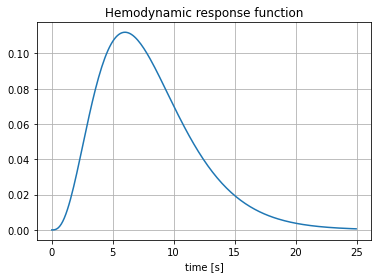

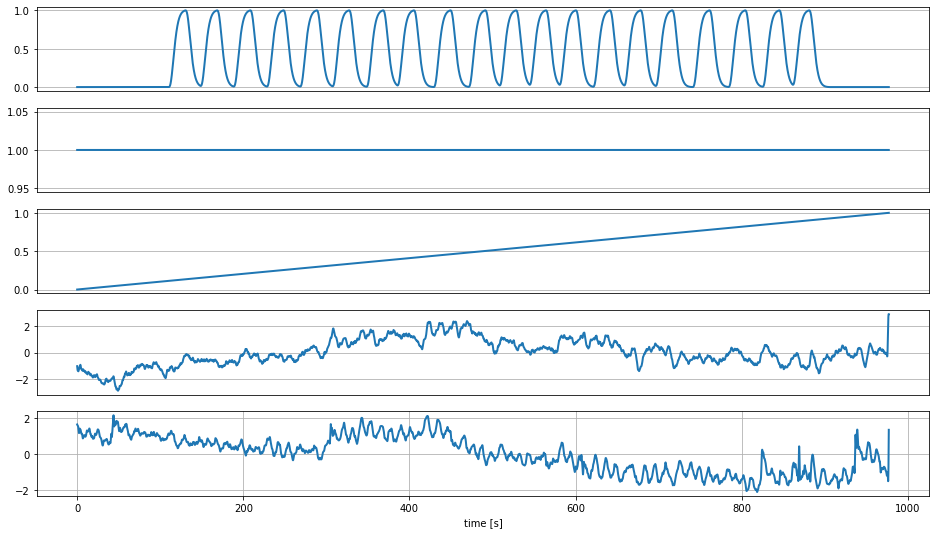

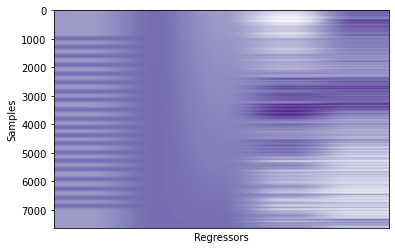

In [7]:
 glm.show_design()

Fit the model:

In [8]:
result_glm = glm.fit(np.delete(time_series, (20, 40), axis=0))
result_pval = glm.result_pval
result_beta = np.array(result_glm[0][:, 0]).astype(float)
result_ttest = np.array(result_glm[2]).astype(float)

Deg of freedom:10


Remove short channels from the data:

In [9]:
[ch for ch in data.chLabels[data.short_channels_ind]]
data.remove_channels(data.short_channels_ind)

INFO:nirs_data:Channel removal complete. 2 channels removed.


Define order in which the channels should be displayed and colors for showing different regions:

In [10]:
order = np.array([ 0, 1,  4,  5,  6,  7,  8,  9, 13, 14, 15, 16, 17, 31, 32, 33, 34, 36, 37, 38, 
                  22, 23, 24, 25, 26, 27, 28, 29, 30, 35,  2,  3, 10, 11, 12, 18, 19, 20, 21])
colors = ['xkcd:violet', 'xkcd:violet', 'xkcd:violet', 'xkcd:violet', 'xkcd:periwinkle', 'xkcd:periwinkle', 
          'xkcd:periwinkle', 'xkcd:periwinkle', 'xkcd:periwinkle', 'xkcd:lavender', 'xkcd:lavender', 
          'xkcd:lavender', 'xkcd:lavender', 'xkcd:deep green', 'xkcd:deep green', 'xkcd:deep green', 
          'xkcd:deep green', 'xkcd:deep green', 'xkcd:deep green', 'xkcd:deep green', 'xkcd:leafy green', 
          'xkcd:leafy green', 'xkcd:leafy green', 'xkcd:leafy green', 'xkcd:leafy green', 'xkcd:leafy green', 
          'xkcd:leafy green', 'xkcd:leafy green', 'xkcd:leafy green', 'xkcd:leafy green', 'xkcd:deep blue', 
          'xkcd:deep blue', 'xkcd:cornflower', 'xkcd:cornflower', 'xkcd:cornflower', 'xkcd:light blue', 
          'xkcd:light blue', 'xkcd:marigold', 'xkcd:marigold'] 
legend = {'Frontal left': 'xkcd:violet', 'Frontal center': 'xkcd:periwinkle', 'Frontal right': 'xkcd:lavender', 
          'Motor left': 'xkcd:deep green', 'Motor center': 'xkcd:leafy green', 'Prefrontal left': 
          'xkcd:deep blue', 'Prefrontal center': 'xkcd:cornflower', 'Prefrontal right': 'xkcd:light blue', 
          'Temporal left': 'xkcd:marigold'}


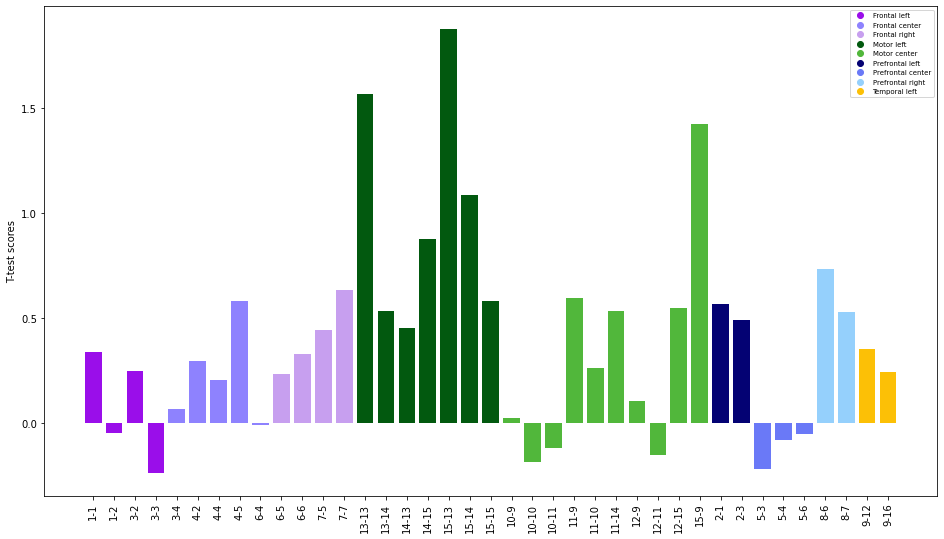

In [11]:
glm.show_results_bar(mode ="t-test", order=order, colors=colors, 
                     labels=np.array(data.chLabels), color_labels=legend)

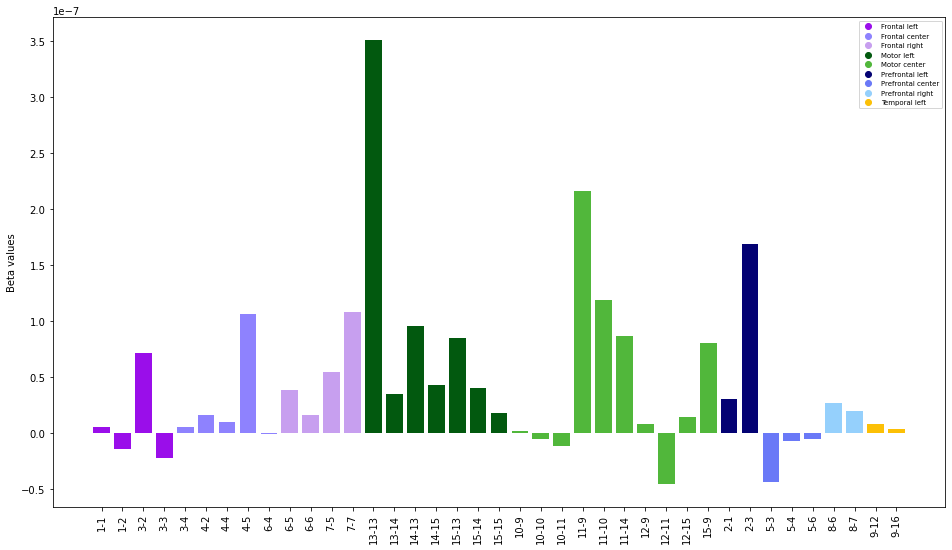

In [12]:
glm.show_results_bar(mode ="beta", order=order, colors=colors, 
                     labels=np.array(data.chLabels), color_labels=legend)

In [13]:
import matplotlib
matplotlib.use("Qt5Agg")

In [17]:
sc = SceneObj(size=(1600, 1000))
kwargs = {}
kwargs['color'] = "magenta"
kwargs['alpha'] = 0.7
kwargs['data'] = result_ttest
#kwargs['radius_min'] = 20               # Minimum radius
#kwargs['radius_max'] = 21              # Maximum radius
kwargs['symbol'] = 'o'            # Source's symbol
kwargs['text_size'] = 10.0
kwargs['text'] = data.chLabels
#kwargs['clim'] = (-10, 10)
cb_kw = dict(cblabel="Task related activation", cbtxtsz=3., border=False, cmap='seismic',
             clim=(-10, 10))

xyz = data.xyz

Creation of a scene
INFO:visbrain:Creation of a scene


In [18]:
s_obj = SourceObj('Sobj', xyz, **kwargs)
s_obj.color_sources(data=result_ttest, cmap='seismic')

b_obj = BrainObj('B2', **cb_kw)

b_obj_vert = b_obj.vertices
s_obj.fit_to_vertices(b_obj_vert)

fitted_coord = s_obj._sources._data['a_position']
s1_obj = SourceObj('Sobj', fitted_coord * 0.95, **kwargs)
s1_obj.color_sources(data=result_ttest, cmap='seismic')
s1_obj.project_sources(b_obj, cmap='seismic', clim=(-10, 10))

vb = Brain(source_obj=s1_obj, brain_obj=b_obj, bgcolor='lightblue')
vb.brain_control(translucent=False)
vb.menuDispCbar.setChecked(True)
vb.rotate('axial_0')
vb.show()

SourceObj(name='Sobj') created
INFO:visbrain:SourceObj(name='Sobj') created
    39 sources detected
INFO:visbrain:    39 sources detected
    Color Sobj using a data vector
INFO:visbrain:    Color Sobj using a data vector
BrainObj(name='B2') created
INFO:visbrain:BrainObj(name='B2') created
SourceObj(name='Sobj') created
INFO:visbrain:SourceObj(name='Sobj') created
    39 sources detected
INFO:visbrain:    39 sources detected
    Color Sobj using a data vector
INFO:visbrain:    Color Sobj using a data vector
    Project the source's modulation (radius=10.0, contribute=False)
INFO:visbrain:    Project the source's modulation (radius=10.0, contribute=False)
    39 sources visibles and not masked used for the projection
INFO:visbrain:    39 sources visibles and not masked used for the projection
VolumeObj(name='brodmann') created
INFO:visbrain:VolumeObj(name='brodmann') created
RoiObj(name='brodmann') created
INFO:visbrain:RoiObj(name='brodmann') created
    brodmann ROI loaded.
INFO:visb

TypeError: setMinimum(self, int): argument 1 has unexpected type 'numpy.float64'